## Setup environment

In [1]:
import matplotlib.pyplot as plt

from simulators.grid_world.grid_world import Maze, simulate_policy, set_granular_reward
from simulators.grid_world import HORIZON

grid_type = "simple"
# feature_type = "one_hot"

feature_type = "simularity"
dimensions = 100
sigma = 0.25

env = Maze(grid_type, feature_type, dimensions=dimensions, sigma=sigma)

## Expert policy

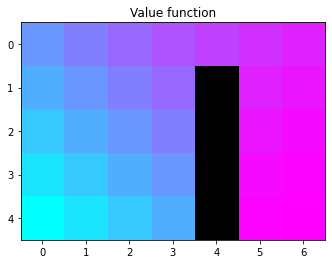

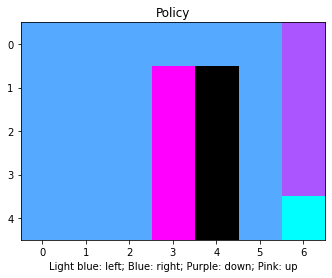

In [5]:
from algorithms.VI_dynamic_programming import value_iteration

expert_Q, expert_policy = value_iteration(env.P, env.R, env.gamma)

# Uncomment if you want to simulate the policy
# simulate_policy(expert_policy, f"../../videos/grid_world/{grid_type}_expert.mp4", env, HORIZON)

env.display_value_function(expert_Q)
env.display_policy(expert_Q)

In [6]:
env = set_granular_reward(env, expert_policy)

## Learninng from limited demonstation

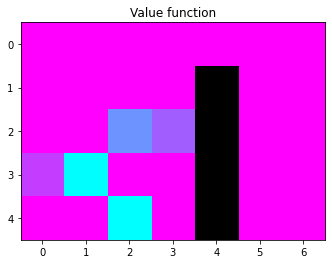

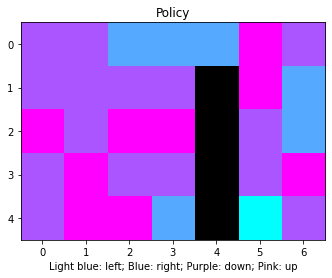

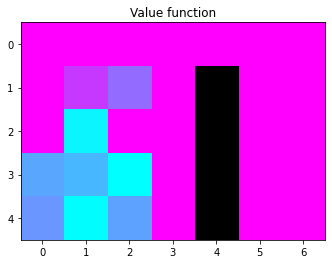

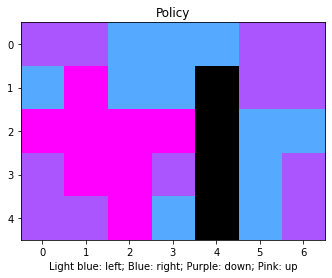

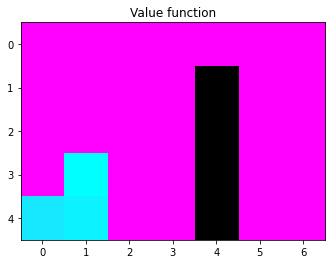

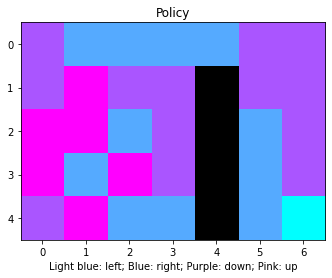

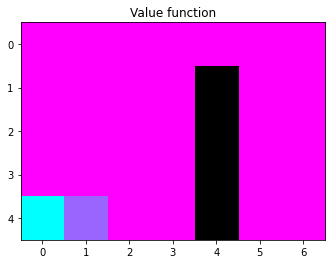

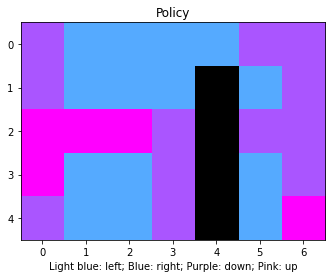

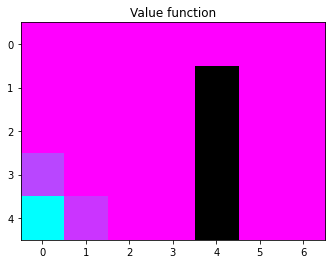

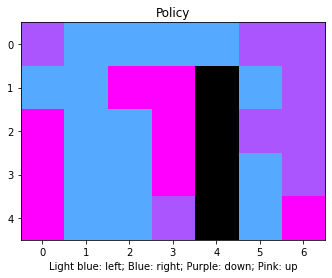

In [5]:
from algorithms.API.lstd import lstd_grid_word

n_expert_samples = 100
n_rl_samples = 500
regularisor = 0.00001
regularisor_bellmann = 0.00001
max_iteration = 5
epsilon_decay_limit = 0.2
regularisor_expert = 1
show_args = {"show_policy":True, "show_value_function": True, "show_statistics": False}

lstd_Q, lstd_policy, buffer_ = lstd_grid_word(env, n_expert_samples, n_rl_samples, regularisor, regularisor_bellmann, max_iteration=max_iteration, epsilon_decay_limit=epsilon_decay_limit, **show_args)

In [6]:
simulate_policy(lstd_policy, f"../../videos/grid_world/{grid_type}_lstd.mp4", env, HORIZON)

ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5233:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM default
ffmpeg version 4.3.3-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avres

## Deep Q-learning from Demonstration, tabular setting

In [272]:
from random import choices
import numpy as np
import matplotlib.pyplot as plt


class Transition:
    def __init__(self, state, action, reward, next_state):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state

        self.next_transition = None

        self.td_loss = None


class ReplayBuffer:
    def __init__(
        self,
        env,
        epsilon_decay,
        n_expert_trajectories=0,
        expert_policy=None,
        n_step_td=10,
        prioritized_replay_rl_exploration=0.001,
        prioritized_replay_expert_exploration=1,
        prioritized_replay_exponent=0.4,
        importance_sampling=0.6,
    ):
        self.env = env
        self.epsilon_decay = epsilon_decay

        self.buffer_expert = []
        self.buffer_rl = []

        if n_expert_trajectories > 0:  # i.e with Demonstration
            self.collect_expert_trajectories(n_expert_trajectories, expert_policy)

        self.n_sted_td = n_step_td
        self.prioritized_replay_expert_exploration = prioritized_replay_expert_exploration
        self.prioritized_replay_rl_exploration = prioritized_replay_rl_exploration
        self.prioritized_replay_exponent = prioritized_replay_exponent
        self.importance_sampling = importance_sampling

        self.last_collected_transition = None
        self.last_sampled_transition = None
        
        self.intial_state_collected = False

    def collect_expert_trajectories(self, n_trajectories, policy):
        for idx_sample in range(n_trajectories):
            self.env.state = choices(self.env._states)[0]
            if self.env.state == self.env.initial_state_distribution:
                self.intial_state_collected = True

            first_transition = True
            terminal = False

            while not terminal:
                action = policy[self.env.state]
                state = self.env.state

                next_state, reward, terminal, _ = self.env.step(action)

                self.buffer_expert.append(Transition(state, action, reward, next_state))
                if not first_transition:
                    self.buffer_expert[-2].next_transition = self.buffer_expert[-1]

                first_transition = False

    def collect_rl_transition(self, Q):
        if self.last_collected_transition is None:
            self.env.state = choices(self.env._states)[0]
            if not self.intial_state_collected and self.env.state != self.env.initial_state_distribution:
                self.env.state = self.env.initial_state_distribution
                self.intial_state_collected = True

        state = self.env.state
                
        if np.random.random() < self.epsilon_decay(len(self.buffer_rl) + len(self.buffer_expert)):
            action = np.random.choice(self.env._actions)
        else:
            action = np.argmax([Q[state, action] for action in self.env._actions])

        next_state, reward, terminal, _ = self.env.step(action)

        self.buffer_rl.append(Transition(state, action, reward, next_state))
        if self.last_collected_transition is not None:
            self.last_collected_transition.next_transition = self.buffer_rl[-1]

        if not terminal:
            self.last_collected_transition = self.buffer_rl[-1]
        else:
            self.last_collected_transition = None

    def update_td_loss_last_sampled_transition(self, td_loss):
        self.last_sampled_transition.td_loss = td_loss

    def sample_a_transition(self):
        td_losses = []
        number_occurences = np.zeros((self.env.S, self.env.A))

        for transition in self.buffer_expert:
            number_occurences[transition.state, transition.action] += 1
            if transition.td_loss is None:
                td_losses.append(None)
            else:
                td_losses.append(
                    (np.abs(transition.td_loss) + self.prioritized_replay_expert_exploration)
                    ** self.prioritized_replay_exponent
                )

        for transition in self.buffer_rl:
            number_occurences[transition.state, transition.action] += 1
            if transition.td_loss is None:
                td_losses.append(None)
            else:
                td_losses.append(
                    (np.abs(transition.td_loss) + self.prioritized_replay_rl_exploration)
                    ** self.prioritized_replay_exponent
                )

        td_losses_array = np.array(td_losses)
        max_td_losses = np.amax(td_losses_array, where=td_losses_array!=None, initial=1)
        probabilities = np.where(td_losses_array == None, max_td_losses, td_losses_array)
        
        for idx_transition, transition in enumerate(self.buffer_expert + self.buffer_rl):
            probabilities[idx_transition] /= number_occurences[transition.state, transition.action]
        
        probabilities /= np.sum(probabilities)

        idx_transition = choices(range(len(probabilities)), probabilities)[0]

        if idx_transition < len(self.buffer_expert):
            return (
                self.buffer_expert[idx_transition],
                True,
                1 / (len(probabilities) * probabilities[idx_transition]) ** self.importance_sampling,
            )
        else:
            return (
                self.buffer_rl[idx_transition - len(self.buffer_expert)],
                False,
                1 / (len(probabilities) * probabilities[idx_transition]) ** self.importance_sampling,
            )

    def sample_n_transitions(self):
        first_transition, is_expert, weight = self.sample_a_transition()

        self.last_sampled_transition = first_transition
        transitions = [first_transition]
        n_transition = 1

        while n_transition < self.n_sted_td and not transitions[-1].next_transition is None:
            transitions.append(transitions[-1].next_transition)
            n_transition += 1

        return transitions, is_expert, weight

    def display_statistics(self, transitions):
        number_occurences = np.zeros(self.env.S)

        for transition in transitions:
            number_occurences[transition.state] += 1

        img = self.env.get_layout_img(number_occurences)
        plt.figure()
        plt.title("Statistics on occurences")
        plt.imshow(img)
        plt.show()

    def display_rl_statistics(self):
        number_occurences = np.zeros(self.env.S)

        for transition in self.buffer_rl:
            number_occurences[transition.state] += 1
        
        print("Max occurences", np.max(number_occurences))
        img = self.env.get_layout_img(number_occurences)
        plt.figure()
        plt.title("Statistics on rl occurences")
        plt.imshow(img)
        plt.show()

In [277]:
import numpy as np


def get_td_loss(transitions, env, Q, Q_target):
    return (
        transitions[0].reward
        + env.gamma * np.max([Q_target[transitions[0].next_state, action] for action in env._actions])
        - Q[transitions[0].state, transitions[0].action]
    )


def get_n_step_td_loss(transitions, env, Q, Q_target, gammas):
    return (
        np.sum([gammas[step] * transitions[step].reward for step in range(len(transitions))])
        + gammas[len(transitions)]
        * np.max([Q_target[transitions[-1].next_state, action] for action in env._actions])
        - Q[transitions[0].state, transitions[0].action]
    )


def get_expert_loss(transitions, env, Q, Q_target, diff_action_from_expert_penalisation):
    return (
        np.max(
            [
                Q_target[transitions[0].state, action]
                + diff_action_from_expert_penalisation * (action != transitions[0].action)
                for action in env._actions
            ]
        )
        - Q[transitions[0].state, transitions[0].action]
    )


def tabular_DQfD(
    env,
    n_expert_trajectories,
    n_step_td,
    n_expert_iterations,
    n_rl_iterations,
    epsilon_decay_limit=0.2,
    update_target_frequency=10,
    td_loss_weight=1,
    n_td_loss_weight=1,
    expert_weight=1,
    diff_action_from_expert_penalisation=0.8,
    show_policy=False,
    show_value_function=False,
    show_statistics=False,
    display_frequency=1,
):
    # from algorithms.DQfD.replay_buffer import ReplayBuffer
    from algorithms.epsilon_greedy import EpsilonDecay

    gammas = [1]
    for pow_gamma in range(1, n_step_td + 1):
        gammas.append(env.gamma * gammas[-1])

    # Average weights
    sum_weights = td_loss_weight + n_td_loss_weight + expert_weight
    td_loss_weight /= sum_weights
    n_td_loss_weight /= sum_weights
    expert_weight /= sum_weights

    if n_expert_trajectories > 0:
        from algorithms.VI_dynamic_programming import value_iteration

        _, expert_policy = value_iteration(env.P, env.R, env.gamma)
    else:
        expert_policy = None

    replay_buffer = ReplayBuffer(
        env,
        EpsilonDecay(limit=epsilon_decay_limit),
        n_expert_trajectories=n_expert_trajectories,
        expert_policy=expert_policy,
        n_step_td=n_step_td,
    )

    Q = np.ones((env.Ns, env.Na)) * -150
    Q_target = np.ones((env.Ns, env.Na)) * -150

    for expert_iteration in range(1, n_expert_iterations + 1):
        transitions, _, weight = replay_buffer.sample_n_transitions()

        if show_statistics and expert_iteration % display_frequency == 0:
            replay_buffer.display_statistics(transitions)

        td_loss = get_td_loss(transitions, env, Q, Q_target)
        n_step_td_loss = get_n_step_td_loss(transitions, env, Q, Q_target, gammas)
        expert_loss = get_expert_loss(transitions, env, Q, Q_target, diff_action_from_expert_penalisation)

        Q[transitions[0].state, transitions[0].action] += weight * (
            td_loss_weight * td_loss + n_td_loss_weight * n_step_td_loss + expert_weight * expert_loss
        )

        replay_buffer.update_td_loss_last_sampled_transition(td_loss)

        if expert_iteration % update_target_frequency == 0:
            Q_target = Q.copy()

        if show_value_function and expert_iteration % display_frequency == 0:
            env.display_value_function(Q)
        if show_policy and expert_iteration % display_frequency == 0:
            env.display_policy(Q)

    print("End of expert phase")
    if show_value_function:
        env.display_value_function(Q)
    if show_policy:
        env.display_policy(Q)
    print("Beginning of rl phase")

    for rl_iteration in range(1, n_rl_iterations + 1):
        replay_buffer.collect_rl_transition(Q)

        transitions, is_expert, weight = replay_buffer.sample_n_transitions()

        if show_statistics and rl_iteration % display_frequency == 0:
            replay_buffer.display_statistics(transitions)
            replay_buffer.display_rl_statistics()

        td_loss = get_td_loss(transitions, env, Q, Q_target)
        n_step_td_loss = get_n_step_td_loss(transitions, env, Q, Q_target, gammas)
        if is_expert:
            expert_loss = get_expert_loss(transitions, env, Q, Q_target, diff_action_from_expert_penalisation)
        else:
            expert_loss = 0

        Q[transitions[0].state, transitions[0].action] += weight * (
            td_loss_weight * td_loss + n_td_loss_weight * n_step_td_loss + expert_weight * expert_loss
        )

        replay_buffer.update_td_loss_last_sampled_transition(td_loss)

        if rl_iteration % update_target_frequency == 0:
            Q_target = Q.copy()
        
        if show_value_function and rl_iteration % display_frequency == 0:
            env.display_value_function(Q)
        if show_policy and rl_iteration % display_frequency == 0:
            env.display_policy(Q)

    return Q, replay_buffer


End of expert phase


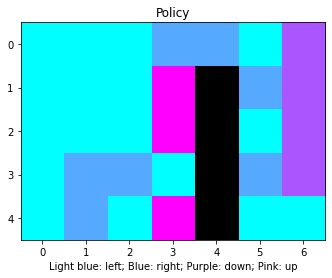

Beginning of rl phase


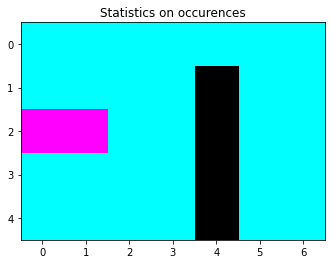

Max occurences 51.0


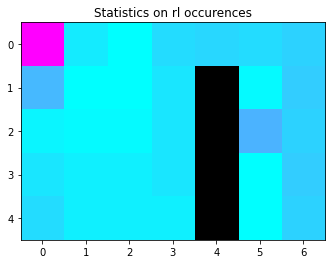

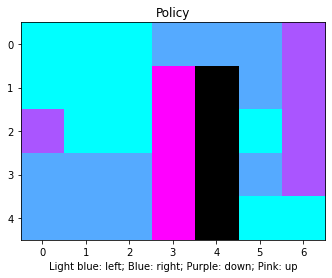

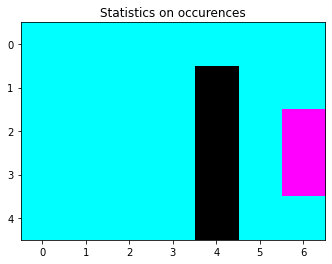

Max occurences 152.0


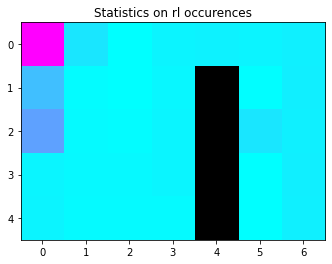

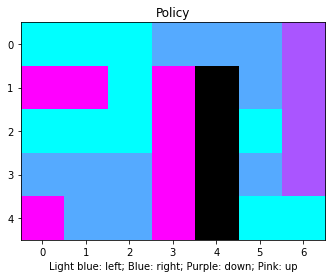

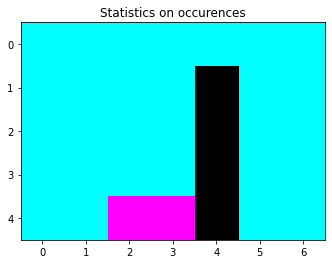

Max occurences 176.0


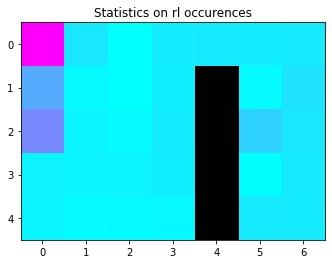

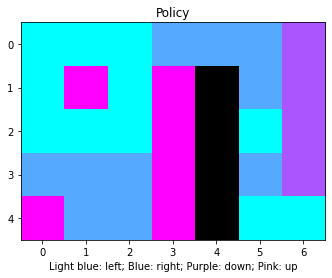

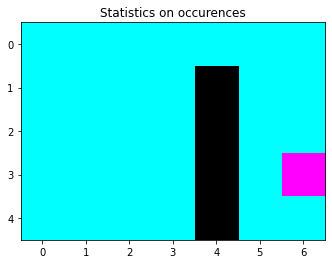

Max occurences 332.0


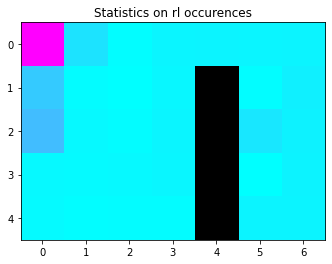

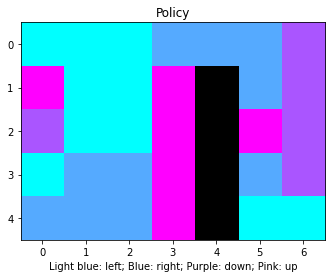

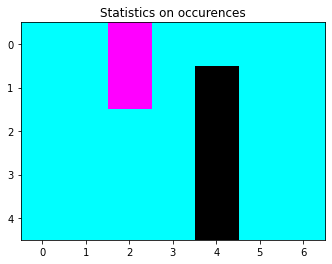

Max occurences 427.0


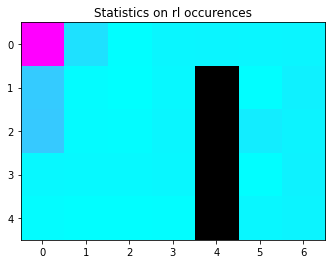

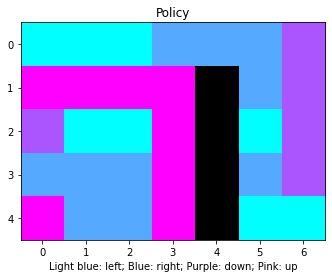

In [279]:
# from algorithms.DQfD.tabular import tabular_DQfD

n_expert_trajectories = 5
n_step_td = 2
n_expert_iterations = 25
n_rl_iterations = 1000
epsilon_decay_limit = 0.2
update_target_frequency = 1
td_loss_weight = 1
n_td_loss_weight = 1
expert_weight = 1
diff_action_from_expert_penalisation = 0.8
show_args = {"show_policy":True, "show_value_function": False, "show_statistics": True, "display_frequency": 200}

DQfD_Q, replay_buffer = tabular_DQfD(
    env,
    n_expert_trajectories,
    n_step_td,
    n_expert_iterations,
    n_rl_iterations,
    epsilon_decay_limit=epsilon_decay_limit,
    update_target_frequency=update_target_frequency,
    td_loss_weight=td_loss_weight,
    n_td_loss_weight=n_td_loss_weight,
    expert_weight=expert_weight,
    diff_action_from_expert_penalisation=diff_action_from_expert_penalisation,
    **show_args,
)

In [155]:
for transition in replay_buffer.buffer_expert:
    if transition.td_loss is not None:
        print(transition.td_loss)

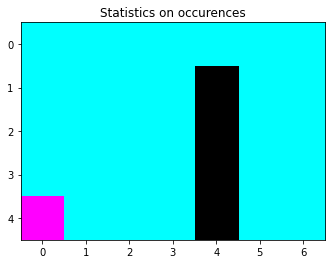

In [159]:
number_occurences = np.zeros(env.S)

for transition in replay_buffer.buffer_expert:
    number_occurences[transition.state] += 1

for transition in replay_buffer.buffer_rl:
    number_occurences[transition.state] += 1

img = env.get_layout_img(number_occurences)
plt.figure()
plt.title("Statistics on occurences")
plt.imshow(img)
plt.show()